# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [1]:
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import os
import acquire
import prepare

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module.

In [130]:
# acquire.scrape_github_data()

In [2]:
df = pd.read_json('final_data.json')

In [3]:
len(df)

676

In [4]:
df.head(1)

,language,readme_contents,repo
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",google-research/bert


## II. Prep

`prep_articles` function from the prepare.py module performs the following:
 - normalize data by removing non-ascii characters, special characters, numbers, white spaces...
 - tokenize words
 - stem and lemmatize words
 - remove stop words and other extraneous words

> We used the functions commented out below to generate a prepped data frame. Then we save the resulting data frame as a .json file.

In [9]:
# df = df[df.readme_contents.notnull()]
# df = prepare.prep_articles(df)
# df.to_json("prepped_df.json")

In [14]:
df = pd.read_json("prepped_df.json")
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",bert new may whole wor...,bert new may whole word mask model thi releas ...,bert new may whole word masking model this rel...,bert new may whole word masking model release ...
1,Rascal,### 项目已迁移至新仓库：[googlehosts/hosts](https://gith...,googlehosts hosts https github com googleho...,googlehost host http github com googlehost hos...,googlehosts host http github com googlehosts h...,googlehosts host googlehosts host issue pull d...
10,Python,"<h1 align=""center""><img src=""https://cdn.rawgi...",align center img src https cdn rawgit co...,align center img src http cdn rawgit com jarun...,align center img src http cdn rawgit com jarun...,align center cdn rawgit jarun googler master g...
100,Ruby,![logo](http://i.imgur.com/i2fElxx.png)\n\n__`...,logo http imgur com felxx png xcpret...,logo http imgur com felxx png xcpretti fast an...,logo http imgur com felxx png xcpretty fast an...,imgur felxx xcpretty fast flexible formatter x...
101,Go,# JX \n\nJX is a command line tool for install...,command line tool for installing and using je...,command line tool for instal and use jenkin ht...,command line tool for installing and using jen...,command line tool installing using jenkins jen...


What are the words we want to exclude?
- http
- banner
- request
- img
- badge
- svg
- www
- com
- png
- welcome
- pr
- style
- flat
- makeapullrequest
- gitpod
- logo
- blue
- green
- brightgreen
- div
- align
- center
- width
- src

Look for documents where there are no programming language indicated.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 99
Data columns (total 6 columns):
language      549 non-null object
original      623 non-null object
normalized    623 non-null object
stemmed       623 non-null object
lemmatized    623 non-null object
cleaned       623 non-null object
dtypes: object(6)
memory usage: 34.1+ KB


In [17]:
df[df.language.isnull()]

,language,original,normalized,stemmed,lemmatized,cleaned
106,None,## List of Continuous Integration services\n\n...,list continuous integration services buil...,list continu integr servic build statu http tr...,list continuous integration service build stat...,list continuous integration service build stat...
107,None,"<aside class=""notice"">\nThis repository has be...",aside class notice this repository has been...,asid class notic thi repositori ha been archiv...,aside class notice this repository ha been arc...,aside class notice repository ha archived rese...
118,None,# \n![Chimp by Xolv.io](./images/chimp.png?raw...,chimp xolv images chimp png raw true ...,chimp xolv imag chimp png raw true import anno...,chimp xolv image chimp png raw true important ...,chimp xolv chimp raw true important announceme...
123,None,"<img src=""https://cdn.rawgit.com/iCHAIT/awesom...",img src https cdn rawgit com ichait awesome...,img src http cdn rawgit com ichait awesom osx ...,img src http cdn rawgit com ichait awesome osx...,cdn rawgit ichait awesome osx master medium aw...
124,None,iOS Good Practices\n==================\n\n_Jus...,ios good practices just l...,io good practic just like softwar thi document...,io good practice just like software this docum...,io good practice like software document rot un...
134,None,"<a rel=""license"" href=""http://creativecommons....",rel license href http creativecommons org...,rel licens href http creativecommon org licens...,rel license href http creativecommons org lice...,rel license creativecommons license align righ...
156,None,# Dive into Machine Learning [![Creative Commo...,dive into machine learning creative commons...,dive into machin learn creativ common licens h...,dive into machine learning creative common lic...,dive machine learning creative common license ...
162,None,# Machine Learning and Data Science Applicatio...,machine learning and data science applications...,machin learn and data scienc applic industri a...,machine learning and data science application ...,machine learning data science application indu...
180,None,"<div align=""center"">\n\t<img width=""500"" heigh...",div align center img width height ...,div align center img width height src media lo...,div align center img width height src medium l...,align center width height medium svg alt aweso...
184,None,﻿## ![Papers We Love](http://paperswelove.org/...,papers love http paperswelove org images l...,paper love http paperswelov org imag logo top ...,paper love http paperswelove org image logo to...,paper love paperswelove top svg gitter badge g...


Since the programming language is necessary to train the model, we will drop these documents from our data set.

In [25]:
df = df[df.language.notnull()]

In [30]:
list_of_languages = df.language.value_counts()
list_of_languages.index

Index(['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 'HTML',
       'Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell', 'C', 'C#',
       'Objective-C', 'Vue', 'Rust', 'Lua', 'Kotlin', 'CoffeeScript',
       'Haskell', 'Dart', 'Scala', 'Groovy', 'Clojure', 'HCL', 'Elixir',
       'Rich Text Format', 'Rascal', 'Emacs Lisp', 'MQL4', 'R', 'PowerShell',
       'Batchfile', 'F#', 'YARA', 'Makefile', 'Nix'],
      dtype='object')

In [31]:
top_languages = ['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 'HTML','Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell', 'C', 'C#']

In [32]:
df[df.language top_languages]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

In [19]:
dfx = df[["language","cleaned"]]

In [20]:
dfx.head()

,language,cleaned
0,Python,bert new may whole word masking model release ...
1,Rascal,googlehosts host googlehosts host issue pull d...
10,Python,align center cdn rawgit jarun googler master g...
100,Ruby,imgur felxx xcpretty fast flexible formatter x...
101,Go,command line tool installing using jenkins jen...


#### A. Distribution of Data, Top Words

In [21]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,129
Python,83
Java,47
PHP,40
Go,37
Jupyter Notebook,25
HTML,23
Swift,22
TypeScript,20
Ruby,18


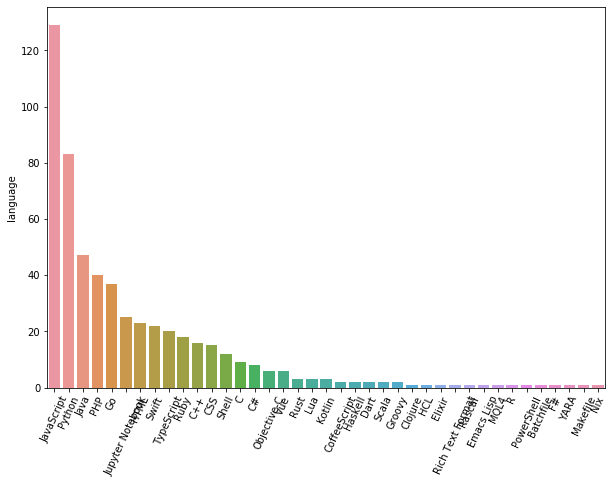

In [22]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.show()

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [23]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

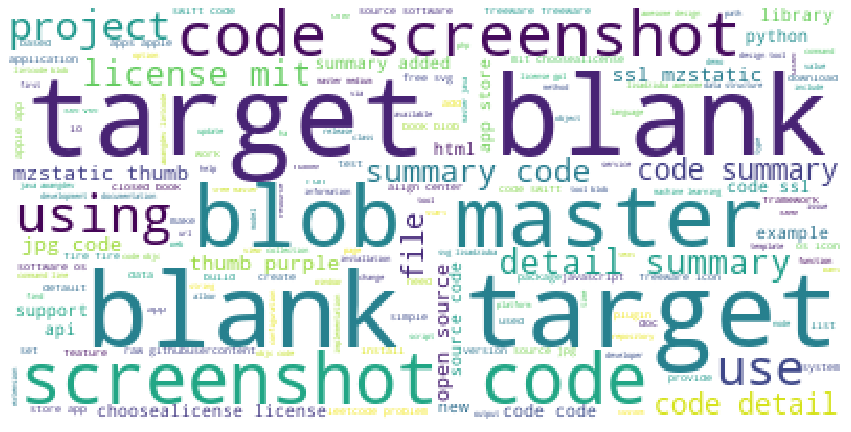

In [24]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

#### C. Common Bigrams

## IV. Explore